In [1]:
# our nice list of imports is in here
#i hate this, but the notebook won't recognize our custom modules w/o it
import sys
sys.path.append("..")
import lib
from lib import utils

import numpy as np
import pandas as pd
import os
import urllib
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential        # keras is only compatible with python 3.6 or lower
import sklearn
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

Using TensorFlow backend.


# Face Mask Detection


### Brief Overview

Simply put, our goal is to create a neural network that will (1) identify face masks or lack thereof on a human face, and (2) determine whether that facemask is correctly worn.


Luckily for us, Kaggle had a contest earlier this year related to (1) -- so a dataset was readily available, and it has proven to be quite effective at training a mask/no-mask neural net with our testing images. (Kaggle)


However, the dataset is extremely lacking when it comes to incorrect mask usage.  We did locate an additional dataset that consists only of faces with correctly worn masks and incorrectly worn masks. (CMFD/IMFD)

### Data

1. Training Data - We have training data from both datasets.  The images in each set have been pre-processed with relevant data written to CSV files to ease the process load.
  + Kaggle Dataset -- 
2. Testing Data - Our testing data consists of 


### Models

To that end, we need a few different models:
1. One to predict whether there's a mask on a face or no mask
  + For this, we will use the Kaggle Dataset, and focus on the two largest features available in it: whether there is a face mask or not.
  + Potentially, we could add the data from the CMFD/IMFD dataset as representations of masks for the training set, since we'll be determining whether they're correct or incorrectly worn in the next stage.  The only concern there is a dataset that's very, very heavy on masks vs. no masks
2. One to predict whether, given a mask is on a face, it is worn correctly
  + For this, we will use the CMFD/IMFD dataset.  There are only two features to this dataset: correctly worn and incorrectly worn face masks.




In [2]:
# define directory paths for easier navigation
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = NOTEBOOK_DIR[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')

KAGGLE_IMAGES_DIR = os.path.join(DATA_DIR, 'images')
CMFD_IMAGES_DIR = os.path.join(KAGGLE_IMAGES_DIR, 'CMFD/images')
IMFD_IMAGES_DIR = os.path.join(KAGGLE_IMAGES_DIR, 'IMFD/images')

# Mask vs. No Mask

In [3]:
# load the training data
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_train.rename(
    columns={'x1': 'x', 'x2': 'y', 'y1': 'w', 'y2': 'h'},
    inplace=True
)
df_train.sort_values('name', axis = 0, inplace = True)
df_train

,name,x,y,w,h,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3464,1802.jpg,160,151,268,265,mask_surgical
3463,1802.jpg,110,71,273,272,face_with_mask
14836,1803.jpg,147,200,288,320,mask_surgical
14835,1803.jpg,126,75,303,333,face_with_mask
...,...,...,...,...,...,...
13555,6433.png,669,205,774,282,mask_surgical
9508,6434.jpg,315,82,775,783,face_with_mask
9507,6434.jpg,343,448,756,774,mask_colorful
9434,6435.jpg,198,86,292,149,mask_surgical


In [4]:
# load the testing data -- if it exists
if os.path.exists(os.path.join(DATA_DIR, 'img_data/kaggle_testing.csv')):

    df_test = pd.read_csv(
        os.path.join(DATA_DIR, 'img_data/kaggle_testing.csv'),
        index_col=0
    )
    df_test.rename(
        columns={'x1': 'x', 'x2': 'y', 'y1': 'w', 'y2': 'h'},
        inplace=True
    )
    df_test.sort_values('name', axis = 0, inplace = True)
else:
    df_test = None

df_test

,name,x,y,w,h,classname
0,0001.jpg,441,108,341,416,NaN
1,0003.jpg,1292,218,865,1088,NaN
2,0004.jpg,630,176,212,266,NaN
3,0006.jpg,441,668,57,70,NaN
4,0007.jpg,922,565,102,121,NaN
...,...,...,...,...,...,...
3161,1796.jpg,469,223,186,229,NaN
3159,1796.jpg,933,207,232,298,NaN
3162,1797.jpg,738,235,483,638,NaN
3163,1799.jpg,757,296,75,86,NaN


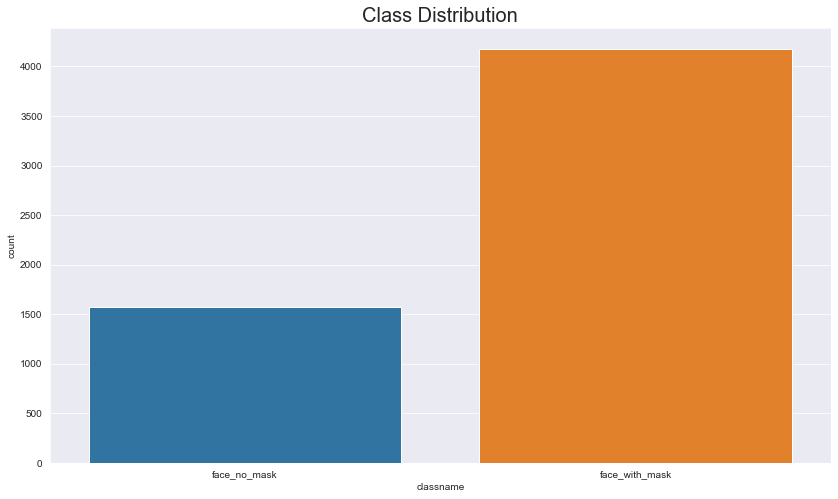

In [5]:
# classes = df_train['classname'].unique()    # uncomment this line and print(classes) 
                                              # to get a full list of features/classnames

# specify which classnames we want to look at
features = [
    'face_with_mask', 
    'face_no_mask', 
#     'mask_colorful', 
#     'face_with_mask_incorrect',
]

### Visualizing Class Distribution
plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)

sns.countplot(x = "classname", data = df_train[df_train["classname"].isin(features)])

## Model Preparations

+ We keep pre-compiled versions of our different models on hand (again, to reduce process/load times)
+ Unless the training data changes, we default to using those existing models

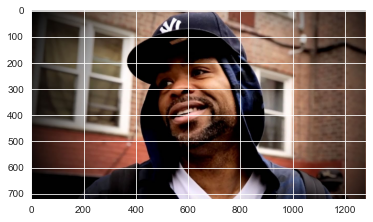

In [9]:
# the training 
image = utils.get_image(name='0001.jpg', source="kaggle", options={'format': 'jpg'})
plt.imshow(image)

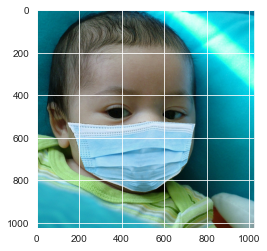

In [11]:
image = utils.get_image(name="00000_Mask.jpg", source="cmfd", options={'format': 'jpg'})
plt.imshow(image)

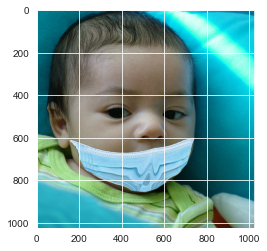

In [14]:
image = utils.get_image(name="00000_Mask_Mouth_Chin.jpg", source='imfd', options={'format': 'jpg'})
plt.imshow(image)